# K-Nearest Neighbors (Regression)

This notebook implements the custom k-nearest neighbors (KNN) regression algorithm on the Palmer Penguins dataset. Here, KNN is used to predict the numerical value of flipper length from bill length, bill depth, and body mass. The objective of this task is to validate the use of the custom KNN regressor, and evaluate its performance for a multi-feature regression problem with one target variable.

The following sections are included in this notebook:
1. **Library Imports**
- Importing the necessary modules, packages, and libraries
- Specifies dependencies and preferred versions
2. **Data Loading and Cleaning**
- Loads the Palmer Penguins dataset with relevant features
- Drops outliers, duplicates, and missing data
- Creates arrays for the features and target variable
3. **Data Visualization**
- Visualizes the correlation between features using a heatmap
- Visualizes the distribution of two features with the target on a 2D color plot
4. **KNN Implementation (2 Features)**
- Implements the custom-built KNN regressor with two input features  
- Visualizes the regression results  
- Evaluates the results across multiple metrics  
5. **KNN Implementation (Changing Parameters)**
- Implements the custom-built KNN regressor with various parameters (*k*, distance metrics)
- Examines the effect on model performance
6. **KNN Implementation (Multiple Features)**
- Implements the custom-built KNN regressor algorithm with more than two features to ensure functionality
- Evaluates the results across multiple metrics
7. **Comparison with Existing Models**
- Runs the scikit-learn version of KNN regression
- Compares the results with the custom-built class to verify the latter

*For a more comprehensive overview of the KNN regression algorithm, code structure, and metrics used, see the associated [README](README.md).*

### Library Imports
This section imports the packages and modules required to run the KNN algorithm. The following dependencies (with recommended versions) are required:
- Python 3.9.6
- Numpy 1.26.4
- Pandas 2.3.3
- Matplotlib 3.9.4
- Seaborn 0.13.2
- Sklearn 1.6.1

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from rice_ml.preprocess import *
from rice_ml.supervised_learning.knn import *
from rice_ml.postprocess.regressionpost import *

### Data Loading and Cleaning
*Loading, preprocessing, and dividing data*

The data used in this notebook comes from Palmer Penguins. Although this dataset is typically used for classification algorithms, it can be adapted to evaluate regression, as it contains a set of numerical features with some relation to one another. It has been selected for its simplicity and clear feature relationships, and because it requires several data cleaning steps that showcase the `rice_ml` preprocessing modules, including handling missing values. The features of interest in this example are *flipper length* (numeric and the target variable for regression), *bill length* (numeric), *bill depth* (numeric), and *body mass* (numeric). 

The data is first loaded as a Pandas DataFrame. Because no variables are categorical, no additional conversion of data is required.

In [2]:
# Loading the basic dataset and selecting features
penguins_df = sns.load_dataset("penguins")
penguin_features = penguins_df[[
    "bill_length_mm", 
    "bill_depth_mm", 
    "flipper_length_mm", 
    "body_mass_g"
]]

display(penguin_features)

,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g
0,39.1,18.7,181.0,3750.0
1,39.5,17.4,186.0,3800.0
2,40.3,18.0,195.0,3250.0
3,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0
...,...,...,...,...
339,NaN,NaN,NaN,NaN
340,46.8,14.3,215.0,4850.0
341,50.4,15.7,222.0,5750.0
342,45.2,14.8,212.0,5200.0


The dataset contains some missing or NaN values (e.g., row 4) and may contain outlier or duplicate rows that will skew the results of the regression. To clean the data, we apply a series of preprocessing steps from the `rice_ml` preprocessing package, including dropping any rows with missing values, outliers, or that are identified to be duplicates of another.

In [3]:
# Cleaning the dataset (dropping rows with missing values, duplicates, or containing outliers)
penguin_features_cleaned_missing = missing_data(penguin_features, 'drop')
penguin_features_cleaned_outliers = outlier_identify(penguin_features_cleaned_missing, 'zscore', drop = True)
penguin_features_cleaned = duplicate_identify(penguin_features_cleaned_outliers, True)
print(f"Cleaned data (first five rows): \n {penguin_features_cleaned[0:5, :]}")

Cleaned data (first five rows): 
 [[  39.1   18.7  181.  3750. ]
 [  39.5   17.4  186.  3800. ]
 [  40.3   18.   195.  3250. ]
 [  36.7   19.3  193.  3450. ]
 [  39.3   20.6  190.  3650. ]]


Two rows have been removed during cleaning, and the dataset no longer contains NaN values. For use in KNN regression and for ease of visualization, the dataset must be split into the target (*flipper length*) and the remaining features.

In [4]:
# Creating two arrays
flipper_length = penguin_features_cleaned[:, 2]
penguin_feature_data = penguin_features_cleaned[:, [0, 1, 3]]
print(f"Array for flipper length (first five entries): \n {flipper_length[0:5]} \n \n \
Array for penguin feature data (first five rows): \n {penguin_feature_data[0:5]}")

Array for flipper length (first five entries): 
 [181. 186. 195. 193. 190.] 
 
 Array for penguin feature data (first five rows): 
 [[  39.1   18.7 3750. ]
 [  39.5   17.4 3800. ]
 [  40.3   18.  3250. ]
 [  36.7   19.3 3450. ]
 [  39.3   20.6 3650. ]]


### Data Visualization
*Correlations and feature plotting*

Once the data has been appropriately cleaned, the relationships between variables can be visualized using a set of methods. We first visualize the correlations between features using a heatmap of a calculated correlation matrix, applied to the cleaned DataFrame that includes all relevant features. Doing so allows for the identification of features that are correlated with the target, and may thus be appropriate for regression using KNN.

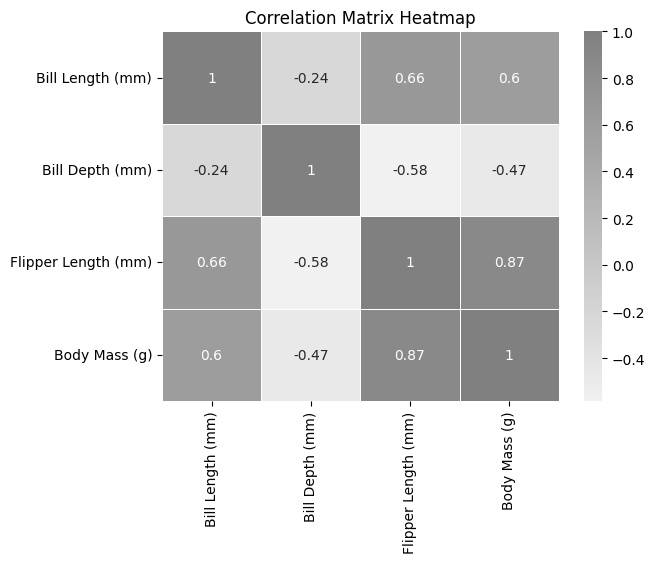

In [5]:
# Creating and plotting a correlation matrix with a heatmap
correlation_matrix = (pd.DataFrame(penguin_features_cleaned, columns = ['Bill Length (mm)', 'Bill Depth (mm)', 'Flipper Length (mm)', 'Body Mass (g)'])).corr()
sns.heatmap(correlation_matrix, annot = True, cmap=sns.light_palette('gray', as_cmap=True), linewidths=0.5)
plt.title('Correlation Matrix Heatmap')
plt.show()

Body mass in grams and bill length in millimeters have the greatest correlation with flipper length (0.87 and 0.66, respectively), while they are moderately correlated with one another (0.6). Consequently, these variables are appropriate for a two-variable KNN, and we will select these as the features for predicting flipper length. To visualize the relationship between the three variables (*bill length*, *body mass*, and *flipper length*), we can create a two-dimensional plot of body mass versus bill length, with the color gradient indicating flipper length.

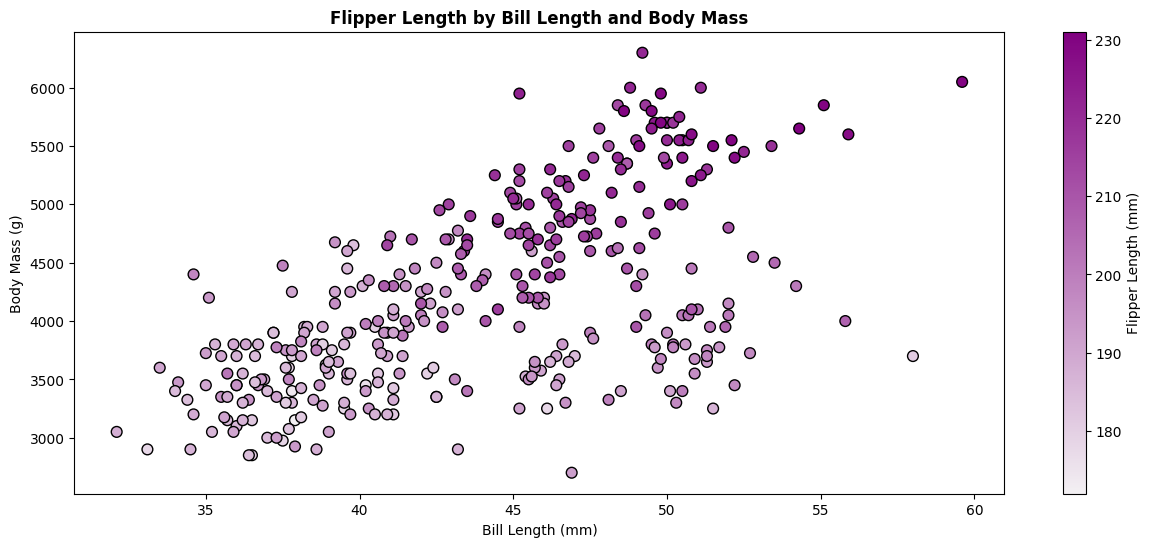

In [6]:
# Plotting bill length and bill depth, color-coded by flipper length
plt.figure(figsize = (15, 6))
plt.scatter(penguin_feature_data[:, 0], penguin_feature_data[:, 2], c = flipper_length, cmap = sns.light_palette('purple', as_cmap=True), s = 60, edgecolor = "k")
cbar = plt.colorbar()
cbar.set_label("Flipper Length (mm)")
plt.xlabel("Bill Length (mm)")
plt.ylabel("Body Mass (g)")
plt.title("Flipper Length by Bill Length and Body Mass", fontweight = 'bold')
plt.show()

There appears to be a general positive trend between bill length and body mass; as bill length increases, so does body mass. Additionally, as these variables increase, flipper length increases as well, indicated by the increase in color intensity towards the upper-right side of the plot. The distribution of this data and the visible trends suggest that it is a good candidate for evaluating the custom KNN regressor.

### KNN Implementation (2 Features)
*Regression using KNN with two features*

This section implements the custom KNN regressor to predict flipper length based on body mass and bill length. It carries out the standardization, splitting, model fit, and prediction calculations.

Prior to fitting the KNN model, we normalize the feature data using z-scores for each feature, calculated using the `preprocess` package. Because the KNN regressor is primarily a distance-based algorithm, it is relatively sensitive to scale, and a feature with larger numerical values will contribute more to the weight calculations. Feature normalization is thus a necessary step in the implementation, as it rescales each feature to prevent skewing results based on feature magnitude and ensures that no one feature overly contributes to regression.

In [7]:
# Standardizing the features
penguin_feature_data_normal = z_score_standardize(penguin_feature_data[:, [0, 2]])
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874 -0.56414208]
 [-0.81112573 -0.50170305]
 [-0.66437972 -1.18853234]
 [-1.32473679 -0.93877623]
 [-0.84781224 -0.68902013]]


Once the data has been scaled, it is split into testing and training arrays. This ensures that the model is not trained and tested on the same set of data, allowing for unbiased evaluation of model performance and preventing overfitting. The data is split in a 70/30 proportion such that the training data is 70% of the total dataset, and the testing data 30%. There are 342 samples in the cleaned dataset, so the training array should have approximately 239/240 samples and the testing should have 102/103. Because this is a regression problem with no class labels, stratification (as done in [KNN classification](knn_classification_example.ipynb)) is not applicable, and the basic `train_test` function is used.

In [8]:
# Splitting the data into training and testing arrays
train_array, test_array, train_targets, test_targets = train_test(penguin_feature_data_normal, flipper_length, random_state = 438)

# Verifying sizes of each array
print(f"Shape of training array: {train_array.shape}")
print(f"Shape of training targets: {train_targets.shape}")
print(f"Shape of testing array: {test_array.shape}")
print(f"Shape of testing targets: {test_targets.shape}")

Shape of training array: (239, 2)
Shape of training targets: (239,)
Shape of testing array: (103, 2)
Shape of testing targets: (103,)


We now perform regression using KNN by creating an instance of the `knn_regressor` class from the supervised learning package, and fitting it on the training data. The previously unseen test data is then provided to the fitted model to predict the flipper length. 

This KNN regressor has the following specifications:
- **k:** 3
- **Distance Metric:** Euclidean
- **Weight:** uniform

In [9]:
# Fitting the model
knn = knn_regressor()
knn.fit(train_array, train_targets)

# Predicting flipper length based on testing data
prediction = knn.prediction(test_array)

When the model has been successfully fitted and returns the flipper length predictions for the test data, we evaluate its performance using a variety of visualization and scoring methods. These include plotting the predictions and calculating the MAE, MSE, RMSE, R2, and adjusted R2. For a description of these metrics, see this [README](README.md).

The plot below is a visualization of the KNN regressor predictions on the test data. The leftmost subplot displays the overall distribution of bill length and body mass for the test data, color-coded for flipper length on a gradient scale. The rightmost subplot displays the same test data, but the gradient values are based on the value predictions from KNN.

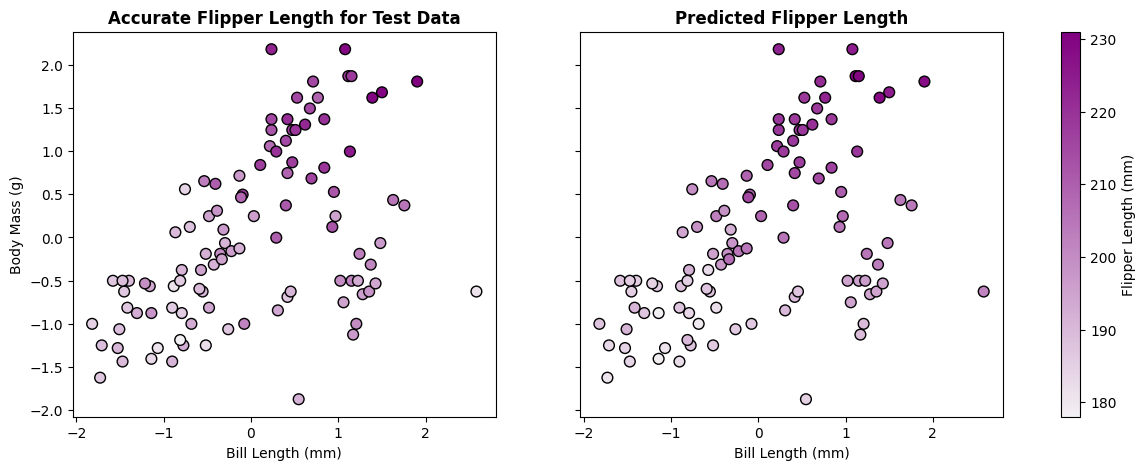

In [10]:
# Plotting bill length and body mass for actual and predicted data, color-coded by flipper length
fig, ax = plt.subplots(1, 2, figsize = (15, 5), sharey = True)
plot_1 = ax[0].scatter(test_array[:, 0], test_array[:, 1], c = test_targets, cmap = sns.light_palette('purple', as_cmap=True), s = 60, edgecolor = "k")
ax[0].set_xlabel("Bill Length (mm)")
ax[0].set_ylabel("Body Mass (g)")
ax[0].set_title("Accurate Flipper Length for Test Data", fontweight = 'bold')

plot_2 = ax[1].scatter(test_array[:, 0], test_array[:, 1], c = prediction, cmap = sns.light_palette('purple', as_cmap=True), s = 60, edgecolor = "k")
ax[1].set_xlabel("Bill Length (mm)")
ax[1].set_title("Predicted Flipper Length", fontweight = 'bold')

cbar = fig.colorbar(plot_1, ax = ax, location = 'right')
cbar.set_label("Flipper Length (mm)")
plt.show()



The custom KNN regressor has a fairly good fit for the test data, with some discrepancies towards the lower-left side of the plot, where flipper length is predicted as lower than the actual value. For a more quantitative evaluation of the model, we produce the numerical evaluation metrics (MAE, MSE, RMSE, R2, and adjusted R2 for two features).

In [11]:
# Evaluating the model
print_model_metrics(prediction, test_targets, n_features = 2)

Model Metrics 
------------- 
MAE: 5.30 
MSE: 45.40 
RMSE: 6.74 
R2: 0.74 
Adjusted R2: 0.73


The results of the evaluation metrics indicate that this KNN regressor is successful in predicting flipper length from bill length and body mass. The R2 and adjusted R2 are fairly high (~0.74), and are not significantly different from one another, indicating that the addition of the two features is not harming model predictions. Additionally, the MAE, MSE, and RMSE are low for the scale of the data, which contains points within the hundreds. Together, this validates the use of the custom KNN regressor for a two-feature regression problem.

### KNN Implementation (Changing Parameters)
*Altering k and distance*

This section implements the custom KNN for predicting flipper length based on bill length and bill depth, but systematically changes a parameter in the model to determine the effects on performance. It first evaluates the model for different values of *k*, using the R2 score as the primary metric.

In [12]:
# Arrays for k-values and R2
k_values = np.arange(1, 16)
r2_k = np.full(len(k_values), np.nan)

# Fitting and scoring the model for each value of k
for i in range(len(k_values)):
    knn = knn_regressor(k = k_values[i])
    knn.fit(train_array, train_targets)
    r2 = knn.scoring(test_array, test_targets)
    r2_k[i] = r2

r2_k

array([0.62092282, 0.75624391, 0.73969292, 0.75789646, 0.76792016,
       0.76832317, 0.78620406, 0.78555403, 0.79262051, 0.79842056,
       0.79996699, 0.80170039, 0.80150926, 0.80030912, 0.80222797])

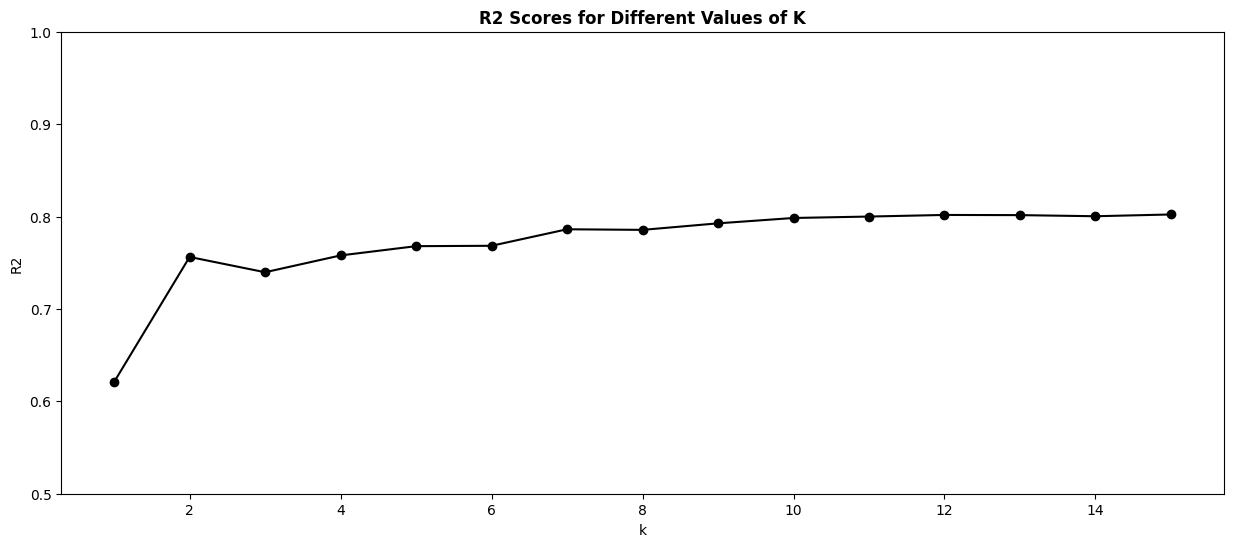

In [13]:
# Plotting the change in R2 across different k-values
plt.figure(figsize = (15, 6))
plt.plot(k_values, r2_k, 'black')
plt.scatter(k_values, r2_k, color = 'black')
plt.title("R2 Scores for Different Values of K", fontweight = 'bold')
plt.xlabel("k")
plt.ylabel("R2")
plt.ylim(0.5, 1)
plt.show()

For larger values of *k* (e.g., > 7), the R2 score of the model tends to plateau, indicating that increasing *k* beyond a certain threshold will not significantly improve model performance. At very low values of *k*, such as 1 or 3, the R2 is considerably lower, and increases up to around a value of 7. Given these results, we will use a k-value of 7 for the remainder of the analysis.

We now evaluate the model for various distance types, using a k-value of 7 and R2 as the metric.

In [14]:
# Arrays for distance type and R2
dist_type = ['euclidean', 'manhattan', 'minkowski', 'minkowski', 'minkowski']
R2_dist = np.full(5, np.nan)

# Fitting and scoring the model for different distance metrics
for i in range(len(dist_type)):
    knn = knn_regressor(k = 7, metric = dist_type[i], p = i + 1)
    knn.fit(train_array, train_targets)
    R2 = knn.scoring(test_array, test_targets)
    R2_dist[i] = R2

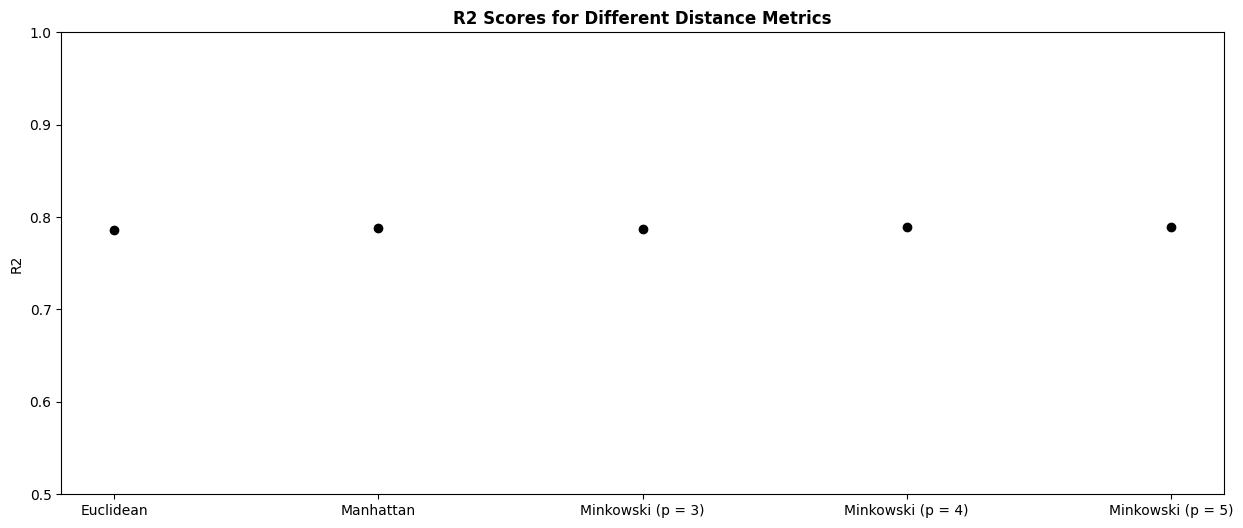

In [15]:
# Plotting the change in R2 across different k-values
plt.figure(figsize = (15, 6))
plt.scatter(["Euclidean", "Manhattan", "Minkowski (p = 3)", "Minkowski (p = 4)", "Minkowski (p = 5)"], R2_dist, color = 'black')
plt.title("R2 Scores for Different Distance Metrics", fontweight = 'bold')
plt.ylabel("R2")
plt.ylim(0.5, 1.0)
plt.show()

The use of different distance metrics generally does not significantly change model performance for a k-value of 7, as each results in an R2 score of around 0.7 to 0.8 with a variation of less than 0.01. Because Euclidean distance is easier to interpret and apply, it will be used for the remainder of the analysis.

### KNN Implementation (Multiple Features)
*Regression using KNN with multiple (three) features*

This section implements the custom KNN class to predict flipper length based on bill depth, bill length, and body mass. As before, it carries out the standardization, splitting, model fit, and prediction calculations.

Prior to fitting the KNN regressor, we normalize the feature data using z-scores for each feature, again calculated using the `preprocess` package. In this case, the entire feature data set (not simply the two selected features) is normalized and used in the KNN analysis. The data is then split into training (70%) and testing arrays (30%). Finally, a new instance of the KNN regressor class is created and fitted with the training data, then used to predict values for samples in the testing data.

This KNN model has the following specifications:
- **k:** 7
- **Distance Metric:** Euclidean
- **Weight:** uniform

In [16]:
# Standardizing the features and target variable
penguin_feature_data_normal_mult = z_score_standardize(penguin_feature_data)
print(f"Standardized feature data (first five rows): \n {penguin_feature_data_normal_mult[0:5, :]}")

Standardized feature data (first five rows): 
 [[-0.88449874  0.78544923 -0.56414208]
 [-0.81112573  0.1261879  -0.50170305]
 [-0.66437972  0.43046236 -1.18853234]
 [-1.32473679  1.08972369 -0.93877623]
 [-0.84781224  1.74898502 -0.68902013]]


In [17]:
# Splitting the data into training and testing arrays
train_array_mult, test_array_mult, train_targets_mult, test_targets_mult = train_test(penguin_feature_data_normal_mult, flipper_length, random_state = 438)

# Verifying sizes of each array
print(f"Shape of training array: {train_array_mult.shape}")
print(f"Shape of training targets: {train_targets_mult.shape}")
print(f"Shape of testing array: {test_array_mult.shape}")
print(f"Shape of testing targets: {test_targets_mult.shape}")

Shape of training array: (239, 3)
Shape of training targets: (239,)
Shape of testing array: (103, 3)
Shape of testing targets: (103,)


In [18]:
# Fitting the model
knn_mult = knn_regressor(k = 7)
knn_mult.fit(train_array_mult, train_targets_mult)

# Predicting flipper length based on testing data
prediction_mult = knn_mult.prediction(test_array_mult)

Model evaluation for three features is done using the quantitative metrics.

In [19]:
# Evaluating the model
print_model_metrics(prediction_mult, test_targets_mult, n_features = 2)

Model Metrics 
------------- 
MAE: 4.08 
MSE: 26.78 
RMSE: 5.18 
R2: 0.85 
Adjusted R2: 0.84


This model predicts flipper length with a higher R2 and adjusted R2 than the two-feature model, as well as a lower MAE, MSE, and RMSE. This suggests that including the additional feature (bill depth) positively contributes to the performance of the model, as does increasing the number of neighbors considered. Consequently, the custom KNN regressor has been shown to run without error and produce reliable results for multi-feature regression.

### Comparison with Existing Models
*Comparison with scikit-learn KNN*

In order to ensure that the custom-built KNN is functioning as intended and providing expected results, it is useful to compare its performance to a KNN regressor from established code. In this section, we rerun the analysis with all three features using the scikit-learn KNN with a matching number of neighbors (7) and distance metrics (Euclidean) to verify the results of the custom KNN.

In [20]:
# Creating a KNN regressor using scikit-learn
from sklearn.neighbors import KNeighborsRegressor
knn_sk = KNeighborsRegressor(n_neighbors = 7, metric = 'euclidean')
knn_sk.fit(train_array_mult, train_targets_mult)
prediction_sk = knn_sk.predict(test_array_mult)

In [21]:
# Printing the model metrics for the scikit-learn KNN regressor
print_model_metrics(prediction_sk, test_targets_mult)

Model Metrics 
------------- 
MAE: 4.08 
MSE: 26.78 
RMSE: 5.18 
R2: 0.85 
Adjusted R2: 0.84


The scikit-learn KNN regressor has an MAE, MSE, RMSE, R2, and adjusted R2 that is essentially identical to that of the custom-built KNN. Therefore, the custom `rice_ml` KNN is able to handle multi-feature regression problems to a professional standard, and nothing in the results are indicative of a malfunctioning or incorrectly implemented algorithm.